# Read data

In [147]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [148]:

activity_cols = {
    "Datum": "date",
    "Ø Pace": "pace_average",
    "Kalorien": "calories",
    "Zeit": "time",
    "Ø Herzfrequenz": "heart_rate_average",
}
df_activities = pd.read_csv(
    "data/raw/all_activities.csv",
    usecols=list(activity_cols.keys())
)
df_activities.rename(columns=activity_cols, inplace=True)

sleep_cols = {
    "Sleep Score 7 Tage": "date",
    "Score": "score",
    "Dauer": "duration",
    "Schlafenszeit": "bedtime",
    "Ruheherzfrequenz": "resting_heart_rate",
    "HFV-Status": "hrv_status",
}
df_sleep = pd.read_csv(
    "data/raw/sleep.csv",
    usecols=list(sleep_cols.keys())
)
df_sleep.rename(columns=sleep_cols, inplace=True)


In [149]:
df_activities.head()

date calories      time heart_rate_average pace_average
0  2025-09-21 09:53:57    2,817  04:35:15                148         6:27
1  2025-09-20 15:18:50      246  00:20:13                144         5:26
2  2025-09-19 12:31:00      210  00:30:18                116         25.4
3  2025-09-15 11:16:13      350  00:30:39                133         5:28
4  2025-09-13 10:51:36      549  00:44:56                144         4:59

In [150]:
df_sleep.head()

date score resting_heart_rate hrv_status  duration   bedtime
0  2025-09-30    77                 44         83  6h 47min  11:22 PM
1  2025-09-29    73                 46         84   9h 6min  10:52 PM
2  2025-09-28    34                 47         84  6h 34min  12:34 AM
3  2025-09-27    93                 41         92  8h 32min  10:39 PM
4  2025-09-26    97                 42         90  7h 50min  10:07 PM

# Clean data/time features

In [151]:

def pace_to_seconds(pace_str):
    try:
        if isinstance(pace_str, str) and ":" in pace_str:
            parts = pace_str.split(":")
            if len(parts) == 2:
                minutes, seconds = int(parts[0]), int(parts[1])
                return minutes * 60 + seconds
            elif len(parts) == 3:  # If format is HH:MM:SS
                hours, minutes, seconds = int(
                    parts[0]), int(parts[1]), int(parts[2])
                return hours * 3600 + minutes * 60 + seconds
        return float(pace_str)
    except Exception:
        return 0


# activities
date = pd.to_datetime(df_activities["date"], errors="coerce")
df_activities["date"] = date.dt.date
df_activities['date'] = pd.to_datetime(df_activities['date'], errors='coerce')
df_activities["time"] = date.dt.time
df_activities["time_seconds"] = df_activities["time"].apply(
    lambda t: t.hour * 3600 + t.minute * 60 +
    t.second if hasattr(t, "hour") else 0
)

df_activities["pace_average"] = df_activities["pace_average"].apply(
    pace_to_seconds)

df_activities.head()

date calories      time heart_rate_average  pace_average  time_seconds
0 2025-09-21    2,817  09:53:57                148         387.0         35637
1 2025-09-20      246  15:18:50                144         326.0         55130
2 2025-09-19      210  12:31:00                116          25.4         45060
3 2025-09-15      350  11:16:13                133         328.0         40573
4 2025-09-13      549  10:51:36                144         299.0         39096

In [152]:
df_activities.dtypes

date                  datetime64[ns]
calories                      object
time                          object
heart_rate_average            object
pace_average                 float64
time_seconds                   int64
dtype: object

In [153]:


numeric_columns = [
    "calories",
    "heart_rate_average",
    "pace_average",
    "time_seconds",
]

for col in numeric_columns:
    if df_activities[col].dtype == "object":
        df_activities[col] = pd.to_numeric(df_activities[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_activities[col] = pd.to_numeric(df_activities[col], errors='coerce')

df_activities.head()

date  calories      time  heart_rate_average  pace_average  \
0 2025-09-21      2817  09:53:57                 148         387.0   
1 2025-09-20       246  15:18:50                 144         326.0   
2 2025-09-19       210  12:31:00                 116          25.4   
3 2025-09-15       350  11:16:13                 133         328.0   
4 2025-09-13       549  10:51:36                 144         299.0   

   time_seconds  
0         35637  
1         55130  
2         45060  
3         40573  
4         39096

In [154]:
df_activities.dtypes

date                  datetime64[ns]
calories                       int64
time                          object
heart_rate_average             int64
pace_average                 float64
time_seconds                   int64
dtype: object

In [155]:
def bedtime_to_seconds(bedtime_str):
    try:
        t = pd.to_datetime(bedtime_str, format="%I:%M %p", errors="coerce")
        if pd.isnull(t):
            return 0
        return t.hour * 3600 + t.minute * 60 + t.second
    except Exception:
        return 0

df_sleep["bedtime_seconds"] = df_sleep["bedtime"].apply(bedtime_to_seconds)

df_sleep["date"] = pd.to_datetime(df_sleep["date"], errors="coerce")

df_sleep["duration"] = pd.to_timedelta(df_sleep["duration"], errors="coerce")
df_sleep["duration_seconds"] = (
    df_sleep["duration"].dt.total_seconds().fillna(0).astype(int)
)

In [156]:
numeric_columns = [
    "score",
    "duration_seconds",
    "bedtime_seconds",
    "resting_heart_rate",
    "hrv_status"
]

for col in numeric_columns:
    if df_sleep[col].dtype == "object":
        df_sleep[col] = pd.to_numeric(df_sleep[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_sleep[col] = pd.to_numeric(df_sleep[col], errors='coerce')

df_sleep.head()

date  score  resting_heart_rate  hrv_status        duration   bedtime  \
0 2025-09-30     77                  44          83 0 days 06:47:00  11:22 PM   
1 2025-09-29     73                  46          84 0 days 09:06:00  10:52 PM   
2 2025-09-28     34                  47          84 0 days 06:34:00  12:34 AM   
3 2025-09-27     93                  41          92 0 days 08:32:00  10:39 PM   
4 2025-09-26     97                  42          90 0 days 07:50:00  10:07 PM   

   bedtime_seconds  duration_seconds  
0            84120             24420  
1            82320             32760  
2             2040             23640  
3            81540             30720  
4            79620             28200

# Corelation Matrix sleep after training

In [157]:
df_latest_activity = df_activities.sort_values('time').groupby('date', as_index=False).last()

df_combined = pd.merge(df_latest_activity, df_sleep, on='date', how='right')
df_combined.count()

date                  365
calories              251
time                  251
heart_rate_average    251
pace_average          251
time_seconds          251
score                 365
resting_heart_rate    365
hrv_status            365
duration              364
bedtime               365
bedtime_seconds       365
duration_seconds      365
dtype: int64

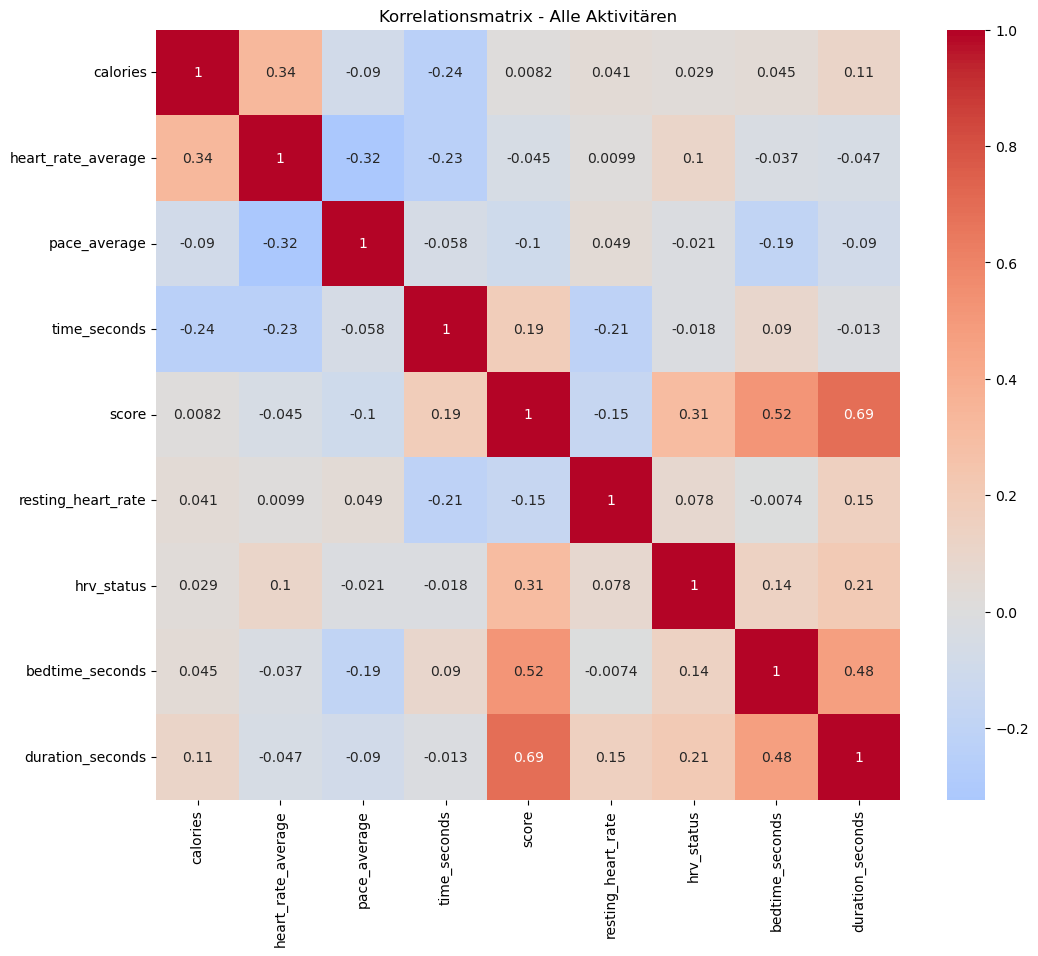

In [158]:
correlation_matrix = df_combined.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix - Alle Aktivitären")
plt.show()

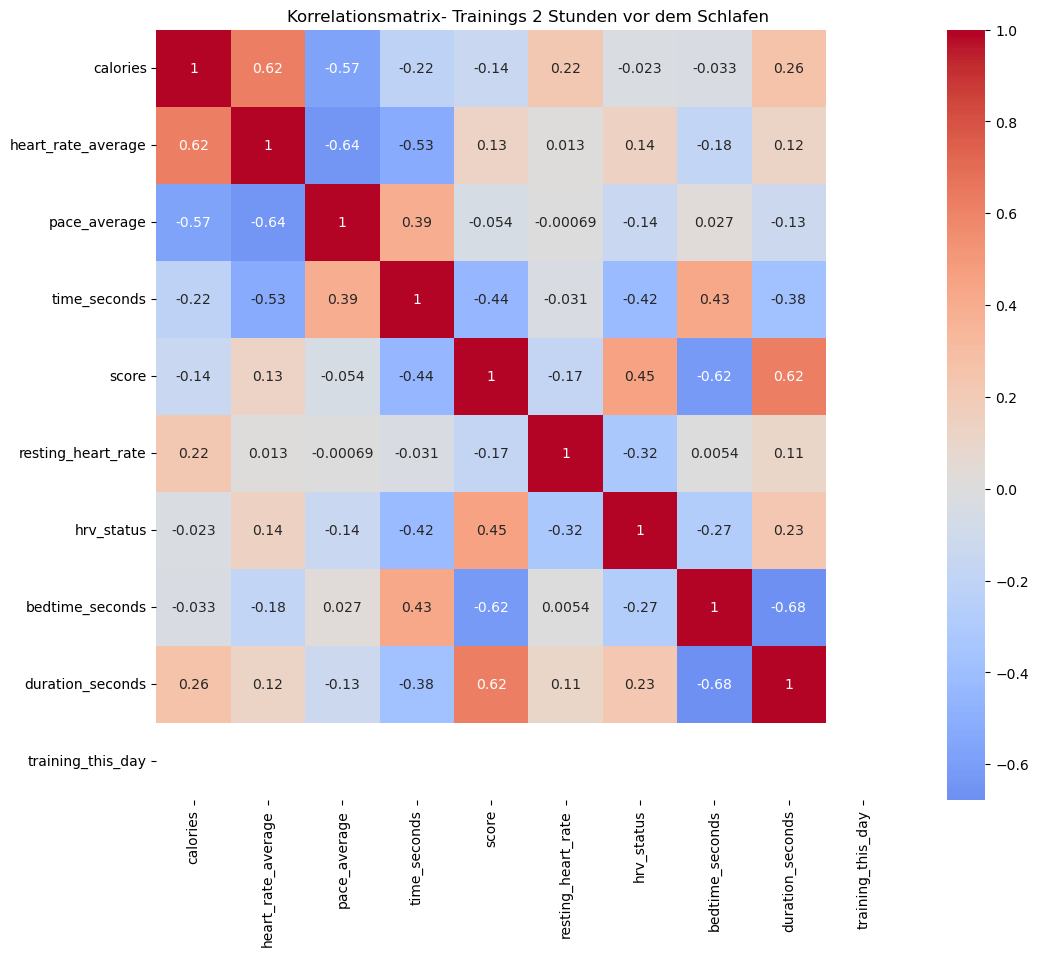

In [161]:
if "time_seconds" in df_combined.columns and "bedtime_seconds" in df_combined.columns:
    df_combined["time_diff_activity_to_sleep_time_seconds"] = (
        df_combined["bedtime_seconds"] - df_combined["time_seconds"] + df_combined["duration_seconds"]
    )

filtered = df_combined[df_combined["time_diff_activity_to_sleep_time_seconds"] < 3 * 60 * 60]
filtered = filtered.drop(columns=["time_diff_activity_to_sleep_time_seconds"])

correlation_matrix = filtered.corr(numeric_only=True)



plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix- Trainings 2 Stunden vor dem Schlafen")
plt.show()

In [162]:
df_combined['training_this_day'] = df_combined['heart_rate_average'].notna()
print(len(df_combined))
print(df_combined['training_this_day'].value_counts())

365
training_this_day
True     251
False    114
Name: count, dtype: int64


/var/folders/cp/r09cdjsd4hzc7p8vtlkxw48h0000gn/T/ipykernel_9401/1781150763.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


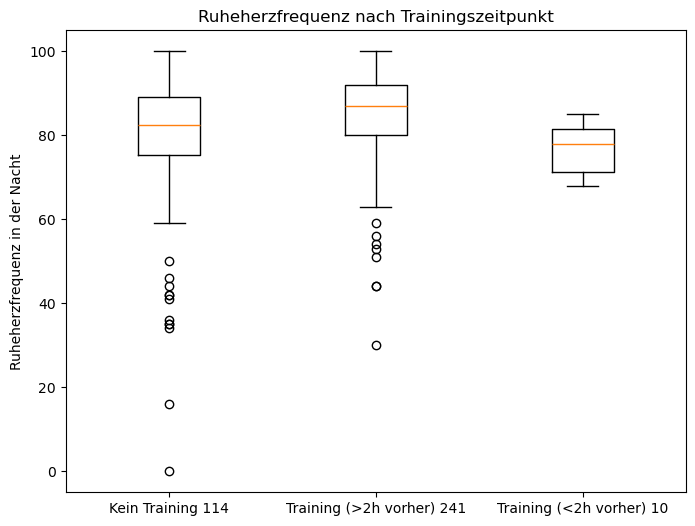

In [ ]:

df_combined['training_this_day'] = df_combined['calories'].notna()
df_combined['training_2h_before_sleep'] = (
    (df_combined['training_this_day']) &
    (df_combined['time_diff_activity_to_sleep_time_seconds'].abs() < 3 * 60 * 60)
)

group_no_training = df_combined[~df_combined['training_this_day']]['score']
group_training_2h_before_sleep = df_combined[df_combined['training_2h_before_sleep']]['score']
group_training_more_than_2h = df_combined[
    df_combined['training_this_day'] & ~df_combined['training_2h_before_sleep']
]['score']


plt.figure(figsize=(8, 6))
plt.boxplot(
    [group_no_training.dropna(), group_training_more_than_2h.dropna(),
     group_training_2h_before_sleep.dropna()],
    labels=['Kein Training ' + str(len(group_no_training.dropna())), 'Training (>2h vorher) ' + str(len(
        group_training_more_than_2h.dropna())), 'Training (<2h vorher) ' + str(len(group_training_2h_before_sleep.dropna()))]
)
plt.ylabel('Sleep Score')
#plt.ylim(35, 55)
plt.title('Sleep Score nach Trainingszeitpunkt')
plt.show()